## Task 3 (7 days)
#### In addition to focusing on macro system scheduling, we also plan to optimize profits from individual user characteristics.
#### In NYC, Uber's pricing plan consists of the following components：
1. A base rate
2. Toll and surcharges
3. Dynamic pricing
4. A booking or marketplace fee
5. Route based adjustments
6. Applicable promotions
7. Pool discounts

##### In addition to the starting price, distance fee, and fuel surcharge, Uber Rides also added a Dynamic Pricing item to dynamically adjust the price. This item is also one of the key points of profitability.
##### In task 1 on the 16th day and the 19th day, we have briefly discussed the general relationship between the travel cost and the start and end points, time, climate, etc. Now we need to uphold this idea and dig out the economic value.
##### In this link, you need to complete a clustering task: distinguish high-value customers through clustering, that is, determine what type of order users are willing to pay a higher price for, Find out which order was Urgent.
##### This task is even closely related to the origin and destination of orders, and the clustering algorithm is used to find "urgent orders/high-value orders". We can appropriately increase Dynamic Pricing for such high-value orders after the trip.
##### In this task, the effect of the basic K-means and its derivative algorithms may be mediocre, but we still recommend you to start practicing from kmeans and explore the basic order portrait.
##### For business-level models, you need to try DBSCAN, agglomerative hierarchical clustering, and try Deep Cluster if possible.
##### There are quite a lot of details for this task to explore, such as how to determine the Loss calculation of this task? The price in the data set is an order that has already taken place. How to find out whether passengers are willing to accept an increase in charges for this order? In the real model reasoning process, the price is neither an output nor an input, so what role does it play in this task？

In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
def parquet_to_df(path):
    df = pq.read_table(path)
    df = df.to_pandas()
    return df

def extend_trips(ogdf, newdf):
    return ogdf.append(newdf, ignore_index=True)

def total_months_to_filename(total_months):
    months = [m[-2:]for m in ['0'+str(m) for m in list(range(1,total_months+1))]]
    trips = pd.DataFrame()

    for month in months:
        path = f'data/fhvhv_tripdata_2021-{month}.parquet'
        df = parquet_to_df(path)
        df = df.sample(n=len(df)//10000, random_state=42)
        trips = extend_trips(trips, df)
    return trips

In [3]:
trips = total_months_to_filename(12)

In [4]:
key_series = ['base_passenger_fare', 'driver_pay']
threshold = 0
for series in key_series:
    percent = (trips[series] < threshold).mean() * 100
    print(f'{series} negative: {percent:.4f}%')
    percent = (trips[series] <= threshold).mean() * 100
    print(f'{series} <= zero: {percent:.4f}%')

original_row_count = len(trips)
condition = (trips['base_passenger_fare'] > 0) & (trips['driver_pay'] > 0)
trips_ = trips[condition]
filtered_row_count = len(trips_)
attrition_rate = ((original_row_count - filtered_row_count) / original_row_count) * 100
print(f'Data Entry Removal Rate: {attrition_rate:.4f}%')

trips_.head()

base_passenger_fare negative: 0.1089%
base_passenger_fare <= zero: 0.2005%
driver_pay negative: 0.0057%
driver_pay <= zero: 0.6475%
Data Entry Removal Rate: 0.8079%


,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B02869,B02869,2021-01-12 13:20:00,2021-01-12 13:22:21,2021-01-12 13:22:21,2021-01-12 13:33:51,181,257,2.340,...,0.88,0.00,NaN,0.0,8.36,N,N,,N,N
1,HV0003,B02867,B02867,2021-01-01 19:12:57,2021-01-01 19:18:29,2021-01-01 19:20:01,2021-01-01 19:49:14,132,229,16.700,...,8.60,2.75,NaN,0.0,53.39,N,N,,N,N
2,HV0003,B02764,B02764,2021-01-31 14:15:46,2021-01-31 14:17:30,2021-01-31 14:17:30,2021-01-31 14:26:58,68,231,2.070,...,1.08,2.75,NaN,0.0,7.04,N,N,,N,N
3,HV0003,B02764,B02764,2021-01-09 15:36:38,2021-01-09 15:36:51,2021-01-09 15:38:51,2021-01-09 15:46:32,233,164,1.060,...,0.74,2.75,NaN,0.0,5.74,N,N,,N,N
4,HV0005,B02510,None,2021-01-07 16:24:13,NaT,2021-01-07 16:29:53,2021-01-07 16:40:36,216,197,2.051,...,0.87,0.00,NaN,0.0,7.66,N,N,N,N,N


In [5]:
weather_2021_path = "data/nyc 2021-01-01 to 2021-12-31.csv"
weather_2021 = pd.read_csv(weather_2021_path)

features = ['temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 
            'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 
            'cloudcover', 'visibility', 'uvindex']

weather_2021 = weather_2021[['datetime']+features]

In [6]:
key_features = ['visibility', 'temp', 'feelslike', 'uvindex', 'humidity', 'snow', 'sealevelpressure']
key_ride_info = ['request_datetime', 'PULocationID', 'DOLocationID', 'base_passenger_fare', 'driver_pay']

essential_trips = trips_[key_ride_info].copy()
essential_weather_2021 = weather_2021[['datetime'] + key_features].copy()

In [7]:
essential_trips.loc[:, 'uber_revenue'] = essential_trips['base_passenger_fare'] - essential_trips['driver_pay']
essential_trips.loc[:, 'profit_to_fare_pct'] = essential_trips['uber_revenue'] / essential_trips['base_passenger_fare']
essential_trips['request_datetime'] = pd.to_datetime(essential_trips['request_datetime'])
essential_trips['date'] = essential_trips['request_datetime'].dt.date.copy()
essential_trips['weekday'] = essential_trips['request_datetime'].dt.weekday.copy()
essential_trips['hour'] = essential_trips['request_datetime'].dt.hour.copy()

In [8]:
weather_2021_df = weather_2021.copy()
weather_2021_df['datetime'] = pd.to_datetime(weather_2021_df['datetime'])
weather_2021_df['date'] = weather_2021_df['datetime'].dt.date

trips_weather_df = essential_trips.merge(weather_2021_df, on=['date'], how='left')

In [9]:
trips_weather_df = trips_weather_df[trips_weather_df['profit_to_fare_pct'] >= -0.66]
trips_weather_df.head()

,request_datetime,PULocationID,DOLocationID,base_passenger_fare,driver_pay,uber_revenue,profit_to_fare_pct,date,weekday,hour,...,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,uvindex
0,2021-01-12 13:20:00,181,257,9.96,8.36,1.60,0.160643,2021-01-12,1,13,...,0.00,0,0.0,0.0,12.0,215.3,1019.5,15.9,15.4,5
1,2021-01-01 19:12:57,132,229,90.75,53.39,37.36,0.411680,2021-01-01,4,19,...,15.33,100,0.0,0.0,15.5,69.8,1028.9,50.6,14.0,3
2,2021-01-31 14:15:46,68,231,9.21,7.04,2.17,0.235613,2021-01-31,6,14,...,1.96,100,10.0,4.3,27.5,73.5,1025.3,65.3,12.7,2
3,2021-01-09 15:36:38,233,164,8.36,5.74,2.62,0.313397,2021-01-09,5,15,...,0.00,0,0.0,0.0,25.9,264.4,1012.2,52.4,16.0,5
4,2021-01-07 16:24:13,216,197,9.83,7.66,2.17,0.220753,2021-01-07,3,16,...,0.00,0,0.0,0.0,22.8,322.7,1018.5,7.6,16.0,5


In [10]:
cols = ['date', 'hour', 'PULocationID', 'DOLocationID', 'base_passenger_fare', 'uber_revenue','profit_to_fare_pct',
        'visibility', 'temp', 'feelslike', 'uvindex', 'humidity', 'snow', 'sealevelpressure','weekday']

trips_weather_df = trips_weather_df[cols].copy().dropna()
trips_weather_df.head()

,date,hour,PULocationID,DOLocationID,base_passenger_fare,uber_revenue,profit_to_fare_pct,visibility,temp,feelslike,uvindex,humidity,snow,sealevelpressure,weekday
0,2021-01-12,13,181,257,9.96,1.60,0.160643,15.4,3.2,1.1,5,55.7,0.0,1019.5,1
1,2021-01-01,19,132,229,90.75,37.36,0.411680,14.0,2.5,-0.2,3,67.8,0.0,1028.9,4
2,2021-01-31,14,68,231,9.21,2.17,0.235613,12.7,-4.9,-9.4,2,60.7,10.0,1025.3,6
3,2021-01-09,15,233,164,8.36,2.62,0.313397,16.0,-0.2,-4.6,5,49.9,0.0,1012.2,5
4,2021-01-07,16,216,197,9.83,2.17,0.220753,16.0,1.9,-2.1,5,54.9,0.0,1018.5,3


In [11]:
holidays_2021 = {
    "2021-01-01": "new_years_day",
    "2021-01-18": "martin_luther_king_jr_day",
    "2021-02-07": "super_bowl_sunday",
    "2021-02-15": "presidents_day",
    "2021-05-31": "memorial_day",
    "2021-06-19": "juneteenth",
    "2021-09-06": "labor_day",
    "2021-09-11": "patriot_day",
    "2021-10-11": "columbus_day",
    "2021-10-31": "halloween",
    "2021-11-25": "thanksgiving_day",
    "2021-12-25": "christmas_day",
}

holidays_df = pd.DataFrame(list(holidays_2021.items()), columns=['date', 'holiday_name'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

trips_weather_df['date'] = pd.to_datetime(trips_weather_df['date'])
trips_weather_df = trips_weather_df.merge(holidays_df, on='date', how='left')

for holiday in holidays_2021.values():
    trips_weather_df[holiday] = trips_weather_df['holiday_name'] == holiday

trips_weather_df = trips_weather_df.drop(columns=['holiday_name'])
holiday_columns = list(holidays_2021.values())

trips_weather_df.head()

,date,hour,PULocationID,DOLocationID,base_passenger_fare,uber_revenue,profit_to_fare_pct,visibility,temp,feelslike,...,super_bowl_sunday,presidents_day,memorial_day,juneteenth,labor_day,patriot_day,columbus_day,halloween,thanksgiving_day,christmas_day
0,2021-01-12,13,181,257,9.96,1.60,0.160643,15.4,3.2,1.1,...,False,False,False,False,False,False,False,False,False,False
1,2021-01-01,19,132,229,90.75,37.36,0.411680,14.0,2.5,-0.2,...,False,False,False,False,False,False,False,False,False,False
2,2021-01-31,14,68,231,9.21,2.17,0.235613,12.7,-4.9,-9.4,...,False,False,False,False,False,False,False,False,False,False
3,2021-01-09,15,233,164,8.36,2.62,0.313397,16.0,-0.2,-4.6,...,False,False,False,False,False,False,False,False,False,False
4,2021-01-07,16,216,197,9.83,2.17,0.220753,16.0,1.9,-2.1,...,False,False,False,False,False,False,False,False,False,False


In [12]:
input_df = trips_weather_df[['PULocationID', 'DOLocationID', 'hour', 'weekday', 'profit_to_fare_pct']]
input_df.head()

,PULocationID,DOLocationID,hour,weekday,profit_to_fare_pct
0,181,257,13,1,0.160643
1,132,229,19,4,0.411680
2,68,231,14,6,0.235613
3,233,164,15,5,0.313397
4,216,197,16,3,0.220753


In [13]:
dummies_PU = pd.get_dummies(input_df['PULocationID'], prefix='PU')
dummies_DO = pd.get_dummies(input_df['DOLocationID'], prefix='DO')
dummies_h = pd.get_dummies(input_df['hour'], prefix='h')
dummies_w = pd.get_dummies(input_df['weekday'], prefix='w')

input_df_dummies = pd.concat([dummies_PU, dummies_DO, dummies_h, dummies_w], axis=1)
input_df_dummies.head()

,PU_3,PU_4,PU_5,PU_6,PU_7,PU_8,PU_9,PU_10,PU_11,PU_12,...,h_21,h_22,h_23,w_0,w_1,w_2,w_3,w_4,w_5,w_6
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [14]:
columns = ['date', 'profit_to_fare_pct', 'base_passenger_fare', 'uber_revenue',
           'visibility', 'temp', 'feelslike', 'uvindex', 'humidity', 'snow', 'sealevelpressure']

grand_input = pd.concat([trips_weather_df[columns].copy(), input_df_dummies], axis=1)
grand_input.head()

,date,profit_to_fare_pct,base_passenger_fare,uber_revenue,visibility,temp,feelslike,uvindex,humidity,snow,...,h_21,h_22,h_23,w_0,w_1,w_2,w_3,w_4,w_5,w_6
0,2021-01-12,0.160643,9.96,1.60,15.4,3.2,1.1,5,55.7,0.0,...,0,0,0,0,1,0,0,0,0,0
1,2021-01-01,0.411680,90.75,37.36,14.0,2.5,-0.2,3,67.8,0.0,...,0,0,0,0,0,0,0,1,0,0
2,2021-01-31,0.235613,9.21,2.17,12.7,-4.9,-9.4,2,60.7,10.0,...,0,0,0,0,0,0,0,0,0,1
3,2021-01-09,0.313397,8.36,2.62,16.0,-0.2,-4.6,5,49.9,0.0,...,0,0,0,0,0,0,0,0,1,0
4,2021-01-07,0.220753,9.83,2.17,16.0,1.9,-2.1,5,54.9,0.0,...,0,0,0,0,0,0,1,0,0,0


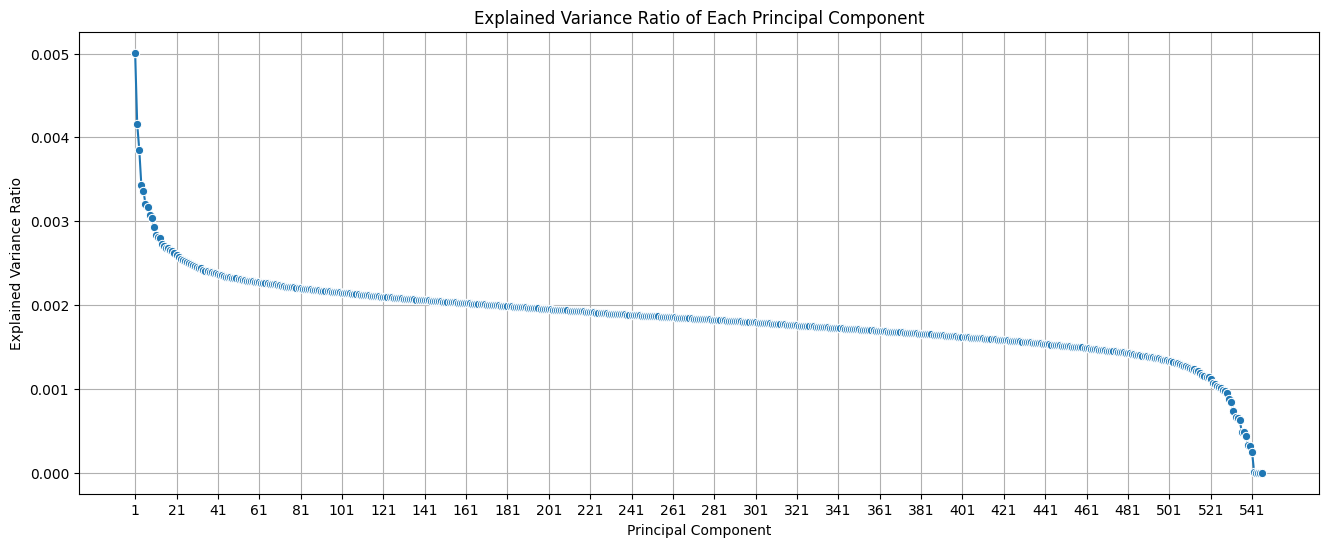

In [15]:
scaler = StandardScaler()
grand_input_X_norm = scaler.fit_transform(grand_input.iloc[:,2:])

pca = PCA()
df_pca = pca.fit_transform(grand_input_X_norm)
explained_variance_ratio = pca.explained_variance_ratio_

pca_df = pd.DataFrame({
    'PC': range(1, len(explained_variance_ratio) + 1),
    'Importance': explained_variance_ratio
})

plt.figure(figsize=(16, 6))
sns.lineplot(data=pca_df, x='PC', y='Importance', marker='o', linestyle='-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Each Principal Component')

x_ticks = range(1, len(explained_variance_ratio) + 1)
plt.xticks(ticks=x_ticks[::20], labels=[str(x) for x in x_ticks[::20]])

plt.grid(True)
plt.show()

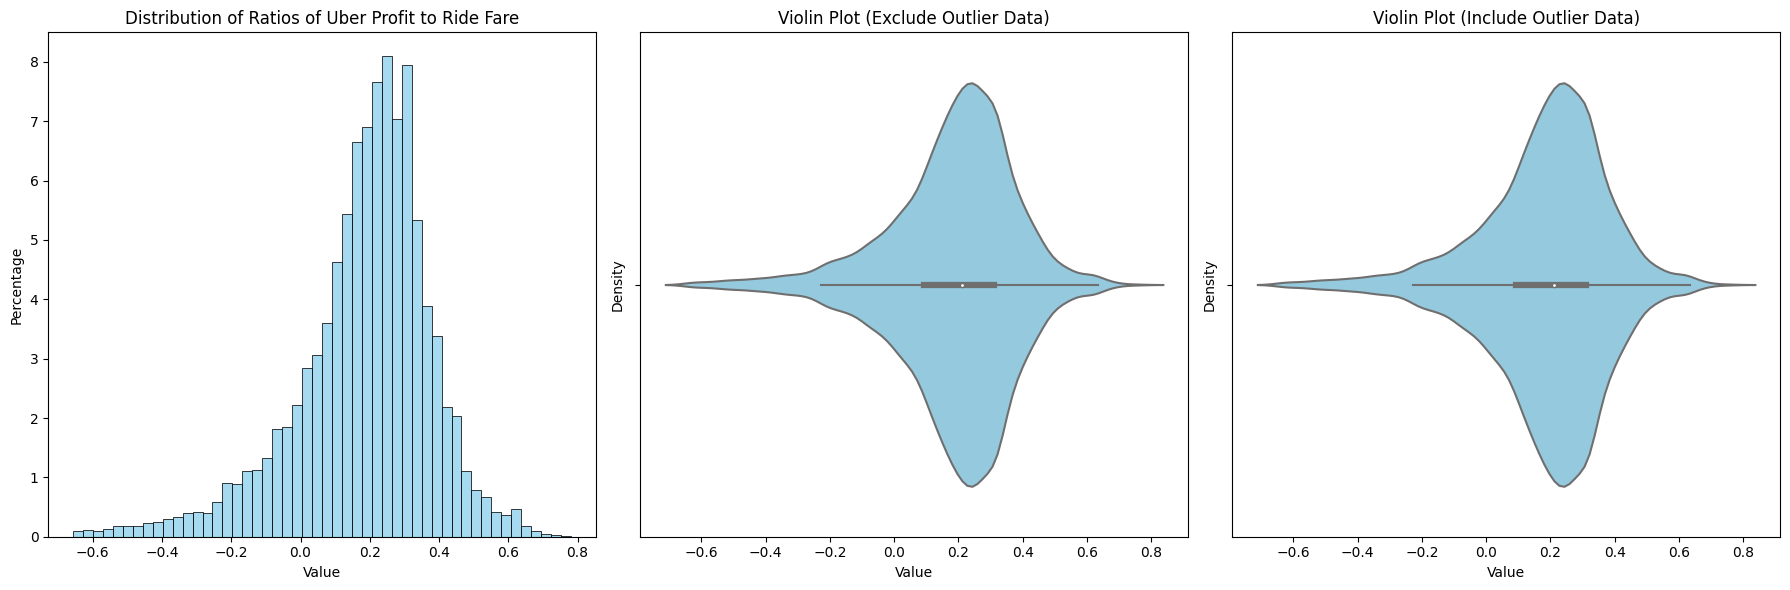

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(trips_weather_df['profit_to_fare_pct'], 
             bins=50, kde=False, color='skyblue', edgecolor='black', stat='percent', ax=axs[0])
axs[0].set_title('Distribution of Ratios of Uber Profit to Ride Fare')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Percentage')

sns.violinplot(x=trips_weather_df['profit_to_fare_pct'], color='skyblue', ax=axs[1])
axs[1].set_title('Violin Plot (Exclude Outlier Data)')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Density')

sns.violinplot(x=trips_weather_df['profit_to_fare_pct'], color='skyblue', ax=axs[2])
axs[2].set_title('Violin Plot (Include Outlier Data)')
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Density')

plt.tight_layout()
plt.show()

#### Data Preprocessing

In [17]:
PCA_COMPONENTS = 24
#PCA_COMPONENTS = 8

pca = PCA(n_components=PCA_COMPONENTS)
pca_transformed = pca.fit_transform(grand_input_X_norm)

pca_df = pd.DataFrame(pca_transformed, columns=[f'PC{i+1}' for i in range(PCA_COMPONENTS)])
pca_df['profit_to_fare_pct'] = grand_input['profit_to_fare_pct'].values
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,profit_to_fare_pct
0,2.018219,-0.639158,0.309450,0.271833,-1.396429,-0.570688,-0.994248,-0.391908,-0.198915,-0.555391,...,0.910772,0.933982,2.010294,3.332071,-0.867680,2.077484,0.005308,-0.719199,-1.458576,0.160643
1,-0.251781,3.068003,6.152437,0.185595,0.002422,0.098450,-0.946739,-0.330855,0.394331,-0.257480,...,0.214520,0.287859,-0.101699,0.572819,-1.557989,1.136526,0.576648,-0.754226,0.118181,0.411680
2,5.877220,1.767653,1.189746,-0.214106,-0.083624,-0.758562,0.678405,0.278138,0.086492,-0.386812,...,-0.794898,0.000734,-1.334750,0.303716,0.308024,-0.190796,-0.348271,1.554585,-0.013413,0.235613
3,1.899062,-0.881470,1.191988,-0.048955,0.264912,-0.979101,1.374721,0.869540,-0.249920,-0.181493,...,-0.316958,0.649454,-0.548125,-1.106242,0.491628,0.191768,-0.747449,1.306739,0.554931,0.313397
4,1.748378,-1.719315,0.284890,-0.430272,-1.396688,3.345078,0.203613,0.206483,0.229426,-2.011708,...,0.296119,4.468624,1.023121,-0.960983,1.459588,-0.173214,-0.281925,-1.197016,-0.040716,0.220753


#### Clustering Analysis

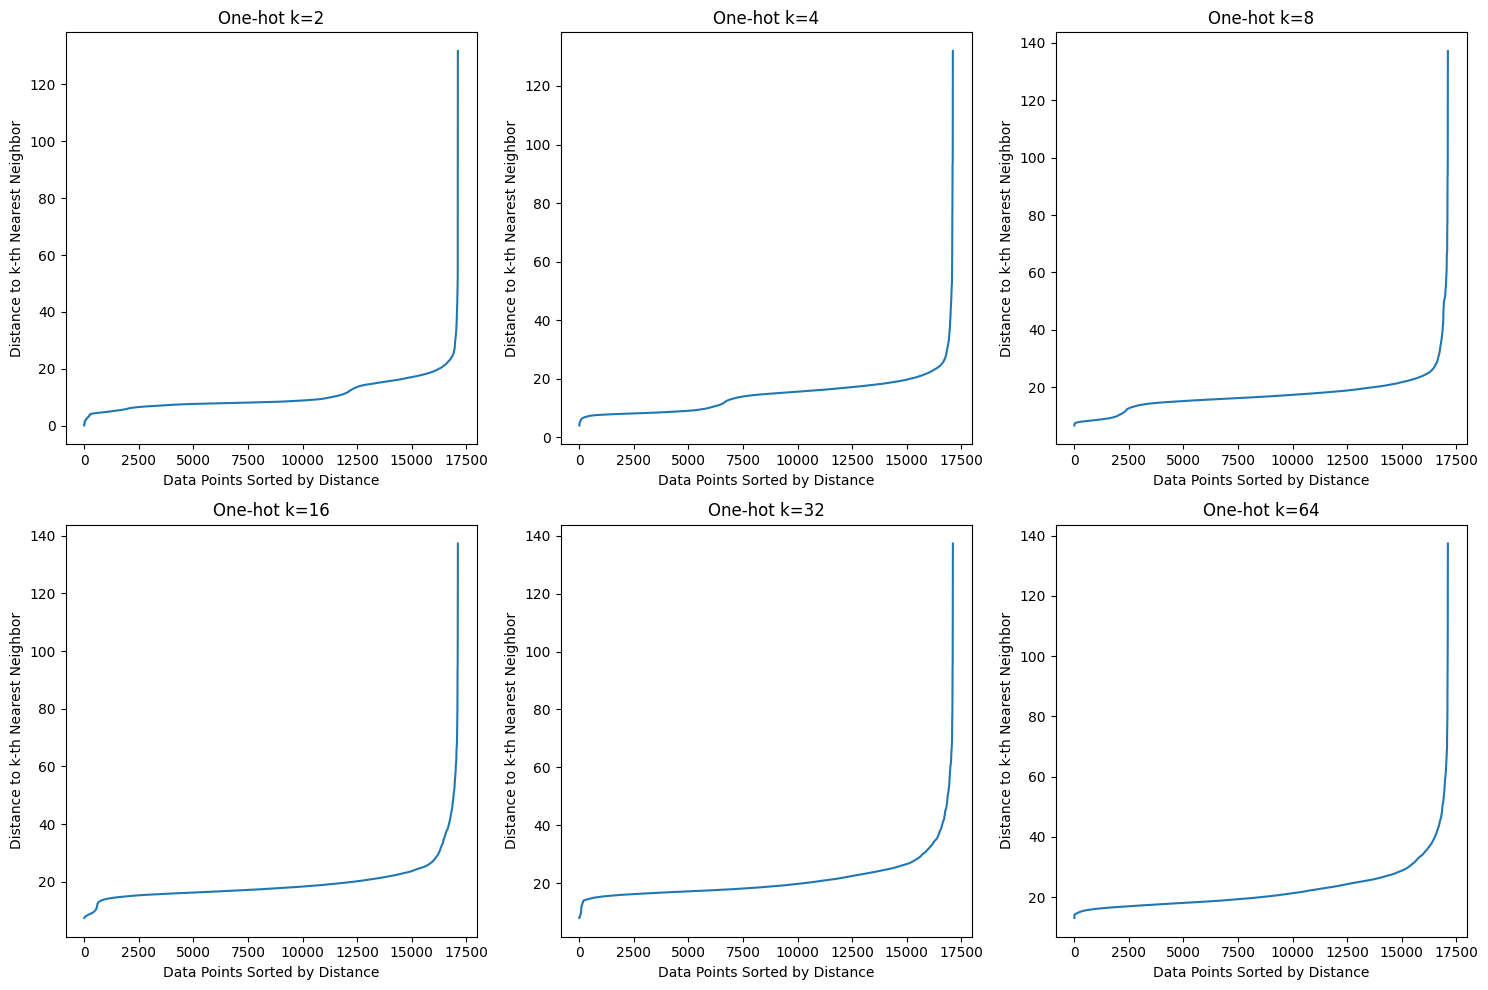

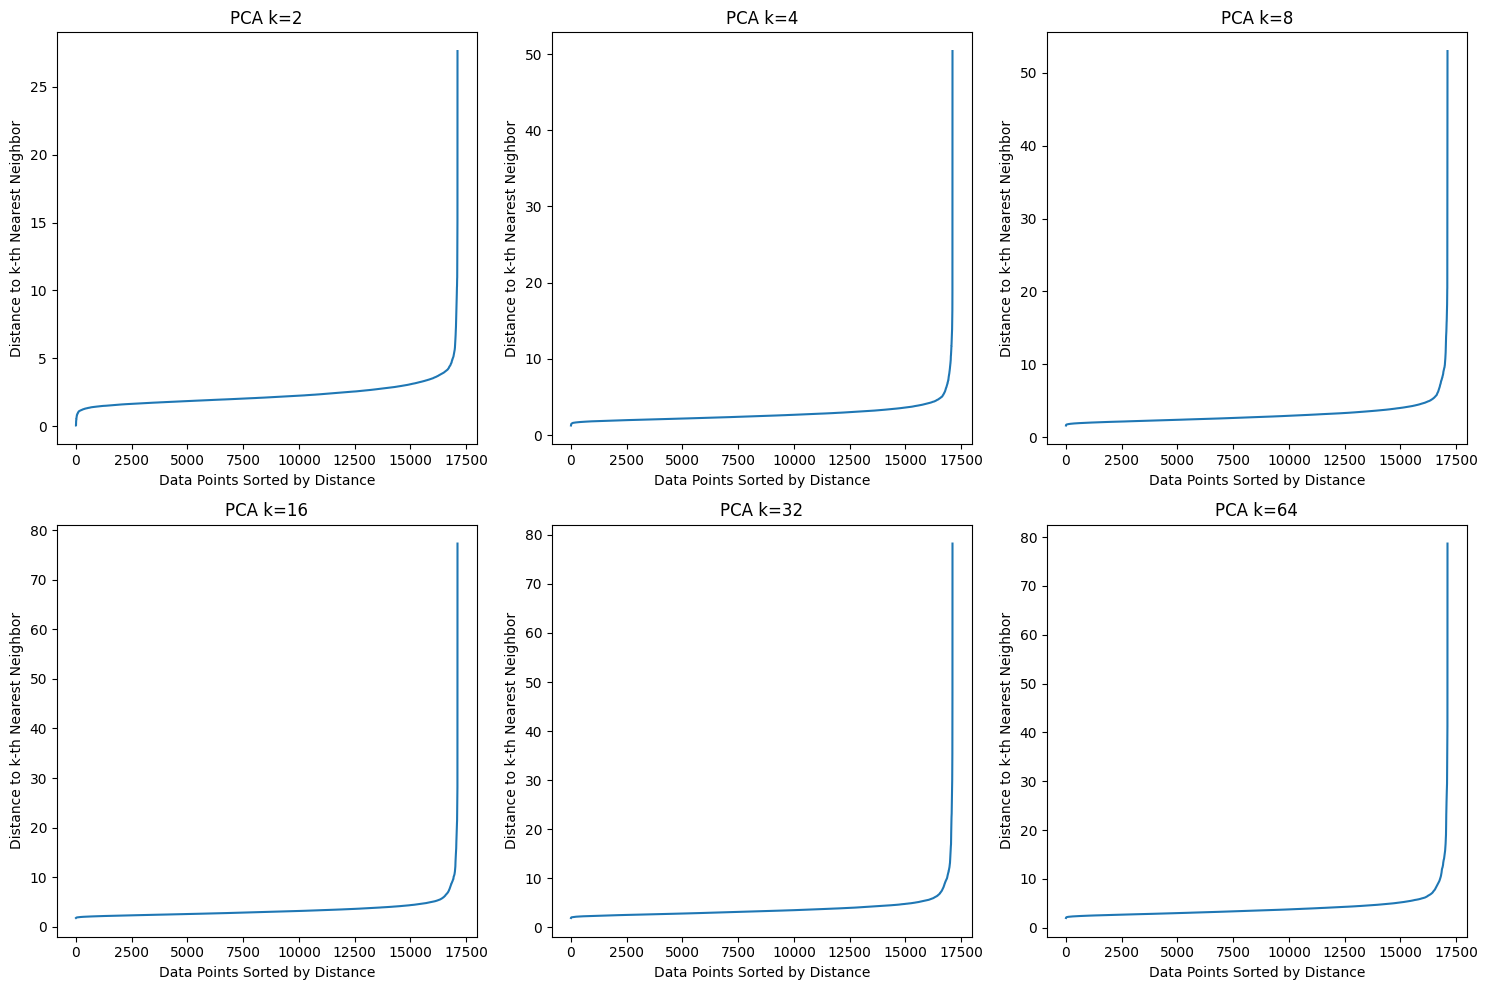

In [18]:
# DBSCAN eps param analysis
ks = [2, 4, 8, 16, 32, 64]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, k in enumerate(ks):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(grand_input_X_norm)
    distances, indices = neighbors_fit.kneighbors(grand_input_X_norm)
    distances = np.sort(distances[:, k-1], axis=0)

    axes[i].plot(distances)
    axes[i].set_title(f'One-hot k={k}')
    axes[i].set_xlabel('Data Points Sorted by Distance')
    axes[i].set_ylabel('Distance to k-th Nearest Neighbor')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, k in enumerate(ks):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(pca_df.drop(columns=['profit_to_fare_pct']))
    distances, indices = neighbors_fit.kneighbors(pca_df.drop(columns=['profit_to_fare_pct']))
    distances = np.sort(distances[:, k-1], axis=0)

    axes[i].plot(distances)
    axes[i].set_title(f'PCA k={k}')
    axes[i].set_xlabel('Data Points Sorted by Distance')
    axes[i].set_ylabel('Distance to k-th Nearest Neighbor')

plt.tight_layout()
plt.show()

In [19]:
# K-means Clustering
kmeans_g = KMeans(n_clusters=5, random_state=42)
clusters_grand_input = kmeans_g.fit_predict(grand_input_X_norm)
grand_input['kmeans_cluster'] = clusters_grand_input

kmeans_p = KMeans(n_clusters=5, random_state=42)
clusters_pca_df = kmeans_p.fit_predict(pca_df.drop(columns=['profit_to_fare_pct']))
pca_df['kmeans_cluster'] = clusters_pca_df

kmeans_stats = grand_input.groupby('kmeans_cluster')['profit_to_fare_pct'].agg(['count', 'mean'])
print("\nKMeans Cluster Statistics: one-hot")
print(kmeans_stats.sort_values(by='kmeans_cluster', ascending=True))

kmeans_stats = pca_df.groupby('kmeans_cluster')['profit_to_fare_pct'].agg(['count', 'mean'])
print("\nKMeans Cluster Statistics: pca")
print(kmeans_stats.sort_values(by='kmeans_cluster', ascending=True))


KMeans Cluster Statistics: one-hot
                count      mean
kmeans_cluster                 
0                  51  0.133241
1                  52  0.165696
2               15668  0.183698
3                 292  0.203280
4                1051  0.188711

KMeans Cluster Statistics: pca
                count      mean
kmeans_cluster                 
0                 244  0.189268
1                5405  0.180165
2                7559  0.177446
3                1517  0.262831
4                2389  0.163782


In [20]:
# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=5)
clusters_grand_input = agg_clustering.fit_predict(grand_input_X_norm)
grand_input['agg_cluster'] = clusters_grand_input

clusters_pca_df = agg_clustering.fit_predict(pca_df.drop(columns=['profit_to_fare_pct']))
pca_df['agg_cluster'] = clusters_pca_df

agg_stats = grand_input.groupby('agg_cluster')['profit_to_fare_pct'].agg(['count', 'mean'])
print("\nAgglomerative Clustering Statistics: one-hot")
print(agg_stats.sort_values(by='agg_cluster', ascending=True))

agg_stats = pca_df.groupby('agg_cluster')['profit_to_fare_pct'].agg(['count', 'mean'])
print("\nAgglomerative Clustering Statistics: pca")
print(agg_stats.sort_values(by='agg_cluster', ascending=True))


Agglomerative Clustering Statistics: one-hot
             count      mean
agg_cluster                 
0             4607  0.188310
1              264  0.188185
2             3211  0.171029
3             3106  0.179483
4             5926  0.190247

Agglomerative Clustering Statistics: pca
             count      mean
agg_cluster                 
0              276  0.184588
1             3051  0.178011
2            10370  0.192276
3             1092  0.163427
4             2325  0.165529


In [21]:
# DBSCAN
dbscan_g = DBSCAN(eps=25, min_samples=25, algorithm='ball_tree')
clusters_grand_input = dbscan_g.fit_predict(grand_input_X_norm)
grand_input['dbscan_cluster'] = clusters_grand_input

dbscan_p = DBSCAN(eps=6, min_samples=8, algorithm='kd_tree')
clusters_pca_df = dbscan_p.fit_predict(pca_df.drop(columns=['profit_to_fare_pct']))
pca_df['dbscan_cluster'] = clusters_pca_df

dbscan_stats = grand_input.groupby('dbscan_cluster')['profit_to_fare_pct'].agg(['count', 'mean'])
print("\nDBSCAN Clustering Statistics: one-hot")
print(dbscan_stats.sort_values(by='dbscan_cluster', ascending=True))

dbscan_stats = pca_df.groupby('dbscan_cluster')['profit_to_fare_pct'].agg(['count', 'mean'])
print("\nDBSCAN Clustering Statistics: pca")
print(dbscan_stats.sort_values(by='dbscan_cluster', ascending=True))


DBSCAN Clustering Statistics: one-hot
                count      mean
dbscan_cluster                 
-1               1654  0.177673
 0              15293  0.184706
 1                 31  0.219161
 2                 26  0.157900
 3                 27  0.176327
 4                 30  0.236547
 5                 28  0.182861
 6                 25  0.193023

DBSCAN Clustering Statistics: pca
                count      mean
dbscan_cluster                 
-1                370  0.184813
 0              16641  0.184300
 1                 67  0.155581
 2                 28  0.110435
 3                  8  0.305743


#### Classification: Unclear Groups

In [22]:
X_train, X_test, y_train, y_test = train_test_split(grand_input_X_norm,
                                                    grand_input['kmeans_cluster'],
                                                    test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00      3155
           3       1.00      0.96      0.98        53
           4       0.99      1.00      1.00       201

    accuracy                           1.00      3423
   macro avg       1.00      0.97      0.98      3423
weighted avg       1.00      1.00      1.00      3423

ROC-AUC Score: 1.0
F1 Score: 0.999110834702851


In [23]:
X_train, X_test, y_train, y_test = train_test_split(pca_df.drop(columns=['profit_to_fare_pct', 'kmeans_cluster', 'dbscan_cluster', 'agg_cluster']),
                                                    pca_df['kmeans_cluster'],
                                                    test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        47
           1       0.96      0.97      0.97      1090
           2       0.96      0.98      0.97      1536
           3       0.97      0.88      0.92       302
           4       0.96      0.95      0.95       448

    accuracy                           0.96      3423
   macro avg       0.96      0.96      0.96      3423
weighted avg       0.96      0.96      0.96      3423

ROC-AUC Score: 0.9986243438316439
F1 Score: 0.9644193739794674


#### Classification: Urgency Grouping

In [24]:
def define_urgency(profit_to_fare_pct, threshold=0.4):
    return (profit_to_fare_pct > threshold).astype(int)

def hike_up_percentage(urgency_prediction, base_hike=2):
    return urgency_prediction * base_hike

grand_input['urgent'] = define_urgency(grand_input['profit_to_fare_pct'])
pca_df['urgent'] = define_urgency(pca_df['profit_to_fare_pct'])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    grand_input_X_norm, 
    grand_input['urgent'], 
    test_size=0.2, 
    random_state=42
)

pipeline_grand_input = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_grand_input.fit(X_train, y_train)
y_pred = pipeline_grand_input.predict(X_test)

print("Classification Report for grand_input:\n", classification_report(y_test, y_pred))
print("ROC-AUC for grand_input:", roc_auc_score(y_test, y_pred))

Classification Report for grand_input:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      3116
           1       0.96      0.24      0.38       307

    accuracy                           0.93      3423
   macro avg       0.95      0.62      0.67      3423
weighted avg       0.93      0.93      0.91      3423

ROC-AUC for grand_input: 0.6184111217505112


In [26]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    pca_transformed, 
    pca_df['urgent'], 
    test_size=0.2, 
    random_state=42
)

pipeline_pca = Pipeline([
    #('classifier', SVC(kernel='rbf', probability=True, random_state=42))
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_pca.fit(X_train_pca, y_train_pca)
y_pred_pca = pipeline_pca.predict(X_test_pca)

print("\nClassification Report for pca_transformed:\n", classification_report(y_test_pca, y_pred_pca))
print("ROC-AUC for pca_transformed:", roc_auc_score(y_test_pca, y_pred_pca))


Classification Report for pca_transformed:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      3116
           1       0.67      0.01      0.01       307

    accuracy                           0.91      3423
   macro avg       0.79      0.50      0.48      3423
weighted avg       0.89      0.91      0.87      3423

ROC-AUC for pca_transformed: 0.5030968668592909
